## ECO-AI Hackathon 2025: Carbon Capture Challenge

This jupyter notebook is part of the Carbon Capture Challenge of the ECO-AI Hackathon 2025.
It aims to give the simplest example on how the challenge can be tackled. For this a mock dataset with a mock target value is supplied. During the hackathon these will be exchanged by the actual datasets. 
Amine-based absorption/desorption processes are crucial for carbon capture but entail high energy demands. Developing predictive models for molecular properties is key to identifying new amines that improve efficiency and reduce costs. CO₂ loading, i.e. the capacity and extent to which the given mixture can absorb the CO₂, is a critical property in the search for novel amine molecules, as it affects various aspects of the CO₂ absorption/desorption process, including mass transfer, equipment sizing, and energy consumption, among others.

The goal during the hackathon will be to develop machine learning models to predict the CO₂ loading of amine molecules as well as the viscosity of 30% amine solutions at two process-relevant temperatures with the highest possible accuracy. Model performance will be evaluated on a test set. A training set will be provided at the first day of the hackathon, containing amine molecules similar to those in the test set. Additionally, participants may use publicly available datasets (e.g., QM9) to augment their training data.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# loading the dataset
path_dataset = './mock_dataset.csv'
# Read the CSV into a pandas dataframe, ensuring correct delimiter
df = pd.read_csv(path_dataset, header=0, sep=',')
# Now inspect columns to confirm
print(df.columns.tolist())
#inspect first 5 rows to check if dataframe is correctly loaded
print(df.head())

['smiles', 'target_value']
                                              smiles  target_value
0  [H]OC([H])([H])[C@]1([H])C([H])([H])C([H])([H]...     -0.758671
1  [H]OC([H])([H])[C@]1([H])C([H])([H])[C@]([H])(...      1.023180
2  [H]C([H])([H])C([H])([H])[C@@]1([H])C([H])([H]...     -0.728048
3  [H]OC([H])([H])[C@]1([H])C([H])([H])OC([H])([H...      0.334588
4  [H]OC([H])([H])[C@]1([H])C([H])([H])C([H])([H]...     -0.662958


In [3]:
# creating smiles alphabet, simply using all individual symbols present in the dataset
smiles_list = np.asanyarray(df.smiles)
smiles_alphabet = list(set(''.join(smiles_list)))
smiles_alphabet.append(' ')  # add a space ' ', for padding all smiles strings to the same length
print(smiles_alphabet)# inspect the resulting alphabet

['-', 'O', '3', 'C', 'N', '=', '(', '1', '+', '\\', '#', '[', ']', '@', '/', '2', 'H', ')', ' ']


In [4]:
# create token to index dictionary for one-hot encoding
smiles_token2idx = {ch: i for i, ch in enumerate(smiles_alphabet)}
print(smiles_token2idx)


{'-': 0, 'O': 1, '3': 2, 'C': 3, 'N': 4, '=': 5, '(': 6, '1': 7, '+': 8, '\\': 9, '#': 10, '[': 11, ']': 12, '@': 13, '/': 14, '2': 15, 'H': 16, ')': 17, ' ': 18}


In [5]:
# Compute the maximum length L among all SMILES strings
largest_smiles_len = len(max(df["smiles"], key=len))

one_hot_encoded_list = []

for smile in df["smiles"]:
    # Pad the string with spaces to ensure length L
    if len(smile) < largest_smiles_len:
        smile = smile.ljust(largest_smiles_len)  # pads with ' ' on the right
    tokens = list(smile)  # tokenize the padded SMILES string
    one_hot = np.zeros((largest_smiles_len, len(smiles_token2idx)), dtype=np.float32)# creating a matrix where the rows correspond to lengths of the longest smiles and the columns to the number of different tokens
    for i, token in enumerate(tokens):# runs over the whole smile string token by token        
        if token in smiles_token2idx:# checks if the current token is within the dictionary created earlier
            one_hot[i, smiles_token2idx[token]] = 1.0 # if yes a 1 is added in the corresponding position in the dictionary
    one_hot_encoded_list.append(one_hot)

# Assign the list of one-hot encoded arrays to the new column
df["smiles_one_hot_encoded"] = one_hot_encoded_list

print(df.head())

                                              smiles  target_value  \
0  [H]OC([H])([H])[C@]1([H])C([H])([H])C([H])([H]...     -0.758671   
1  [H]OC([H])([H])[C@]1([H])C([H])([H])[C@]([H])(...      1.023180   
2  [H]C([H])([H])C([H])([H])[C@@]1([H])C([H])([H]...     -0.728048   
3  [H]OC([H])([H])[C@]1([H])C([H])([H])OC([H])([H...      0.334588   
4  [H]OC([H])([H])[C@]1([H])C([H])([H])C([H])([H]...     -0.662958   

                              smiles_one_hot_encoded  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  


In [6]:
# Initialize lists for X and Y data
x_smiles = []
y_smiles = []
# Prepare SMILES data
for i, row in df.iterrows():
    # Flatten and the one-hot encoding for SMILES such that it can be used as in input for our ML model
    flattened_smiles = row['smiles_one_hot_encoded'].flatten()

    # Append to X and Y
    x_smiles.append(flattened_smiles)
    y_smiles.append(row['target_value'])

In [7]:
# in this example we will use a simple feed forward neural network, with one hidden layer using the flattened one-hot encoded smiles as an input to predict our "target value"
class SimpleANN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


1995


Epoch 1/100, Train Loss: 1.1291, Val Loss: 1.6573
Epoch 2/100, Train Loss: 1.0618, Val Loss: 1.7840
Epoch 3/100, Train Loss: 0.9487, Val Loss: 1.7334
Epoch 4/100, Train Loss: 0.8655, Val Loss: 1.8491
Epoch 5/100, Train Loss: 0.7688, Val Loss: 2.0073
Epoch 6/100, Train Loss: 0.6133, Val Loss: 2.1570
Epoch 7/100, Train Loss: 0.5290, Val Loss: 2.1416
Epoch 8/100, Train Loss: 0.4505, Val Loss: 2.5268
Epoch 9/100, Train Loss: 0.3792, Val Loss: 2.7274
Epoch 10/100, Train Loss: 0.3579, Val Loss: 2.0781
Epoch 11/100, Train Loss: 0.2911, Val Loss: 2.2644
Epoch 12/100, Train Loss: 0.3946, Val Loss: 2.2585
Epoch 13/100, Train Loss: 0.2262, Val Loss: 2.6355
Epoch 14/100, Train Loss: 0.2660, Val Loss: 2.4958
Epoch 15/100, Train Loss: 0.1708, Val Loss: 2.5873
Epoch 16/100, Train Loss: 0.1194, Val Loss: 2.4798
Epoch 17/100, Train Loss: 0.1148, Val Loss: 2.6919
Epoch 18/100, Train Loss: 0.0928, Val Loss: 2.3433
Epoch 19/100, Train Loss: 0.0863, Val Loss: 2.6701
Epoch 20/100, Train Loss: 0.0950, Val Lo

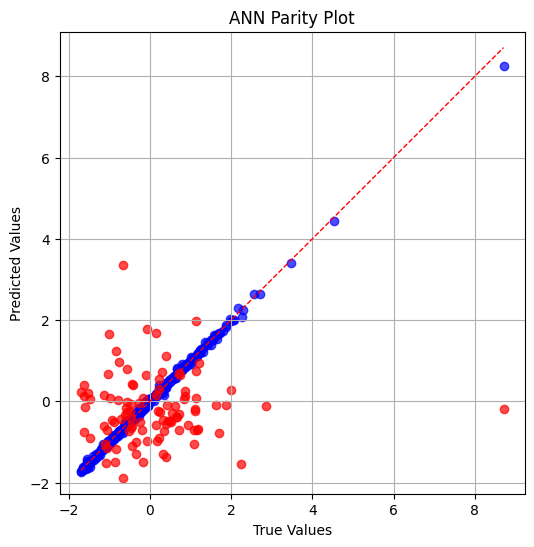

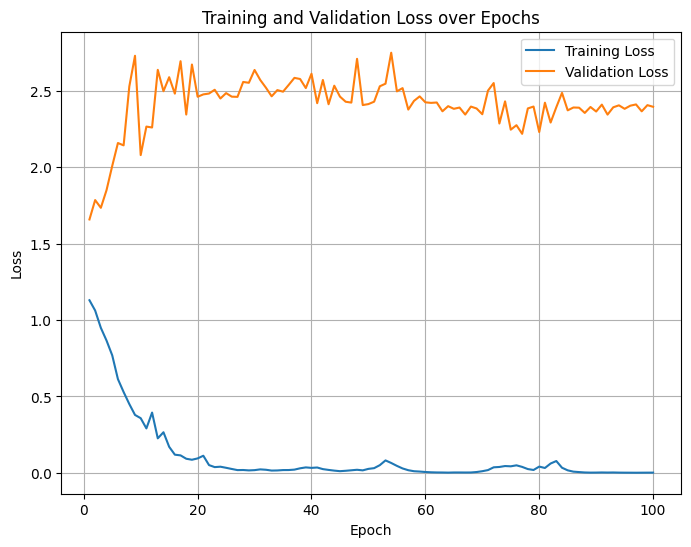

In [8]:
# Convert lists to numpy arrays
X = np.array(x_smiles)
y = np.array(y_smiles)

# X = np.array(X).reshape(-1, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Split indices creating the training and validation set respectively
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Use training indices to compute mean and std
train_y_tensor = y_tensor[train_indices.indices]
mean_y = train_y_tensor.mean()
std_y = train_y_tensor.std()

# Scale y_tensor (scaled using train set statistics to prevent data leakage)
y_tensor_scaled = (y_tensor - mean_y) / std_y

# Create the TensorDataset again with the scaled y_tensor
scaled_dataset = TensorDataset(X_tensor, y_tensor)

# Create Subsets using the same indices
train_dataset = torch.utils.data.Subset(scaled_dataset, train_indices.indices)
val_dataset = torch.utils.data.Subset(scaled_dataset, val_indices.indices)

# Define DataLoaders for training and validation
batch_size = 8 # set batch size for training the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


# Instantiate the model
input_dim = X.shape[1] # extract and set the input dimensions to correspond to the lengths of our flattened one-hot encoded smiles
print(X.shape[1]) # print to get an idea about the dimensionality of one-hot encoded smiles 
model = SimpleANN(input_dim)# intialise our model

# 4. Define the loss function and optimizer
criterion = nn.MSELoss()# set the criterion to be mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)# set the optimizer to use ADAM and a learning rate of 0.0001
# Initialize a list to keep track of losses
loss_tracking = []
# 5. Training loop
num_epochs =100# set the number of epochs to train the model
for epoch in range(num_epochs):
    model.train()# set model in training mode
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_X)# calculate our output for current batch of X values with current model parameters
        loss = criterion(outputs, batch_y)# compute the loss
        # Backward pass and optimization
        loss.backward()# calculates the gradients of the loss function with respect to each weight in the ANN
        optimizer.step()# performs the optmization step to update the model parameters
        train_loss += loss.item() * batch_X.size(0)# keeps track of training loss

    # Calculate average loss over the entire training set
    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    val_loss /= len(val_loader.dataset)

    # Print epoch progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    # Append the losses for this epoch to the tracking list
    loss_tracking.append({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})



# Convert the loss tracking list to a DataFrame
loss_df = pd.DataFrame(loss_tracking)


# Set the model to evaluation mode
model.eval()

# Initialize lists to store actual and predicted values
actual_val = []
predicted_val = []
actual_train = []
predicted_train = []


# Iterate over the test set
with torch.no_grad():
    for batch_X, batch_y in val_loader:  # Assuming you have a test_loader
        outputs = model(batch_X)
        actual_val.extend(batch_y.cpu().numpy().flatten())
        predicted_val.extend(outputs.cpu().numpy().flatten())

    for batch_X, batch_y in train_loader:  # Assuming you have a test_loader
        outputs = model(batch_X)
        actual_train.extend(batch_y.cpu().numpy().flatten())
        predicted_train.extend(outputs.cpu().numpy().flatten())



# Convert lists to numpy arrays for plotting
actual_train = np.array(actual_train)
predicted_train = np.array(predicted_train)
actual_val = np.array(actual_val)
predicted_val = np.array(predicted_val)

# Visualize the training results which are apparently very poor, so a lot room for improvement for you!

# Create the parity plot
plt.figure(figsize=(6, 6))
plt.scatter(actual_train, predicted_train, alpha=0.7, color='blue', label='Train')
plt.scatter(actual_val, predicted_val, alpha=0.7, color='red', label='Validation')
plt.plot([actual_train.min(), actual_train.max()], [actual_train.min(), actual_train.max()], color='red', linestyle='--', linewidth=1)

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("ANN Parity Plot")
plt.grid(True)
plt.axis('equal')  # Ensure 1:1 scaling on both axes
plt.show()


# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(loss_df["epoch"], loss_df["train_loss"], label="Training Loss")
plt.plot(loss_df["epoch"], loss_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()